## API Management Introduction:

The API management dataset is a log of providers, endpoints, and consumers that are part of an API management system. When a consumer uses a provider endpoint through API management, this dataset logs information about the transaction, including response time, method, gateway type, and payment type. This dataset contains approximately one million transactions between different providers and consumers.

The goal of this project is to analyze an API management dataset to gain insights into API usage and performance within an organization. The dataset consists of various columns such as log_level, code, method, username, Price, gwStatus, planName, received_at, log_type, providerName, gatewayName, response_status, status, response_Time, paymentType, endpoint, providerResponse_Time, gwCode, call_type, and api_type.

The project is divided into three main phases: data cleaning, exploration, and feature engineering. During the data cleaning phase, various data quality issues is addressed, such as missing values, duplicates, and outliers. In the exploration phase, the cleaned dataset is visualized and analyzed to gain insights into the distribution of the data and identify any patterns or trends. Finally, in the feature engineering phase, new features are created to help improve the accuracy of the analysis.

By completing these phases, the project aim to provide valuable insights into API usage and performance, which could help inform decision-making within the organization. The project is a critical step towards understanding and optimizing the organization's API management strategy.


## Import important libraries and read data

In [227]:
! pip install -q plotly_express

In [228]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [229]:
df = pd.read_parquet('/content/api_management_clean.parquet')

## Overview

In [230]:
df.shape

(1000000, 20)

In [231]:
df.head()

,log_level,code,method,username,Price,gwStatus,planName,received_at,log_type,providerName,gatewayName,response_status,status,response_Time,paymentType,endpoint,providerResponse_Time,gwCode,call_type,api_type
0,WARNING,429,POST,username_1376,10,0,Silver,2022-06-28T10:24:46.000000Z,INPUT,provider_186,gateway_657,200,1,958,PREPAID,endpoint_1201,479,600,EXTERNAL,undefined
1,WARNING,335,GET,username_1376,10,0,Bronze,2021-09-18T05:43:21.000000Z,OUTPUT,provider_186,gateway_657,400,0,576,POSTPAID,endpoint_1201,288,404,EXTERNAL,undefined
2,WARNING,404,POST,username_1376,20,0,Gold,2022-04-03T03:52:45.000000Z,OUTPUT,provider_186,gateway_657,401,0,395,POSTPAID,endpoint_1201,197,300,INTERNAL,oauth
3,ERROR,400,POST,username_1376,20,0,Bronze,2023-02-14T18:38:42.000000Z,INPUT,provider_186,gateway_657,200,1,342,POSTPAID,endpoint_1201,171,408,INTERNAL,undefined
4,WARNING,429,GET,username_1376,50,0,Bronze,2021-07-12T11:09:06.000000Z,OUTPUT,provider_186,gateway_657,403,0,330,PREPAID,endpoint_1201,165,404,EXTERNAL,undefined


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   log_level              1000000 non-null  object
 1   code                   1000000 non-null  object
 2   method                 1000000 non-null  object
 3   username               1000000 non-null  object
 4   Price                  1000000 non-null  object
 5   gwStatus               1000000 non-null  object
 6   planName               1000000 non-null  object
 7   received_at            1000000 non-null  object
 8   log_type               1000000 non-null  object
 9   providerName           1000000 non-null  object
 10  gatewayName            1000000 non-null  object
 11  response_status        1000000 non-null  object
 12  status                 1000000 non-null  object
 13  response_Time          1000000 non-null  int64 
 14  paymentType            1000000 non-

## Data Cleaning and Handling 


### Check Nulls

In [233]:
df.isnull().sum()

log_level                0
code                     0
method                   0
username                 0
Price                    0
gwStatus                 0
planName                 0
received_at              0
log_type                 0
providerName             0
gatewayName              0
response_status          0
status                   0
response_Time            0
paymentType              0
endpoint                 0
providerResponse_Time    0
gwCode                   0
call_type                0
api_type                 0
dtype: int64

### Check Duplicates

In [234]:
duplicates = df[df.duplicated()]

if len(duplicates) > 0:
    print("Duplicates found!")
    print(duplicates)
else:
    print("No duplicates found.")

No duplicates found.


### Response times cant be zero

In [235]:
df[(df["providerResponse_Time"] == 0) | (df["response_Time"] == 0)].count()[0]

5001

These rows should be dropped

In [236]:
df = df.drop(df[(df["providerResponse_Time"] == 0) | (df["response_Time"] == 0)].index).reset_index(drop = True)

### Dealing with outliers

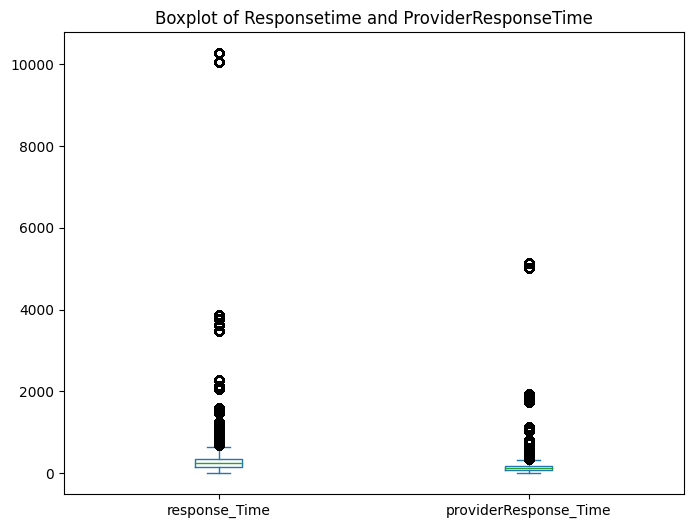

In [237]:
df.plot( kind = "box", figsize = (8,6), title = 'Boxplot of Responsetime and ProviderResponseTime')
plt.show()

In [238]:
# using interquantile rage to detect and replace outliers.
def lower_upper_bound_finder(column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    LB = Q1 - 1.5 * (Q3 - Q1)
    UB = Q3 + 1.5 * (Q3 - Q1)

    print(f''' The lower bound for {column_name} feature is {LB}\n The higher bound for {column_name} feature is {UB}''')
    
    return LB,UB


In [239]:
LB_provider_response_time, UB_provider_response_time = lower_upper_bound_finder('providerResponse_Time')

 The lower bound for providerResponse_Time feature is -77.0
 The higher bound for providerResponse_Time feature is 331.0


In [240]:
LB_response_time, UB_response_time = lower_upper_bound_finder('response_Time')

 The lower bound for response_Time feature is -155.5
 The higher bound for response_Time feature is 664.5


### Explore important features

In [241]:
def create_displot(column_name, title ):
    # Calculate the mean and standard deviation of the column 
    mean_A = df[column_name].mean()
    std_A = df[column_name].std()

    # Find outliers greater than mean + 2 std and smaller than mean - 2 std
    outliers = df.loc[(df[column_name] > mean_A + 2*std_A) | (df[column_name] < mean_A - 2*std_A), column_name]

    # Replace outliers with the mean value of the column 
    for index in outliers.index:
        df.loc[index, column_name] = mean_A

    sns.displot(df[column_name],color='red',bins=100,height=5, aspect=2).fig.suptitle(title)
    plt.show()

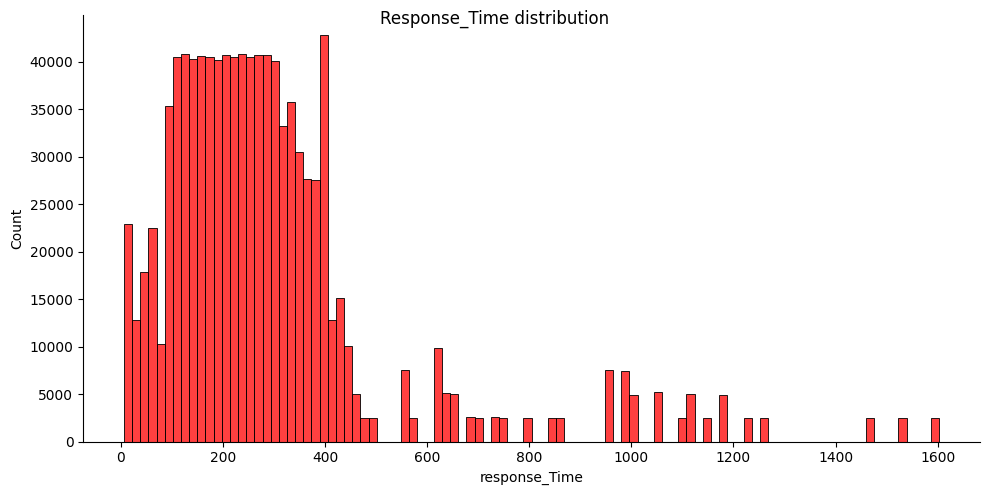

In [242]:
create_displot('response_Time', 'Response_Time distribution' )

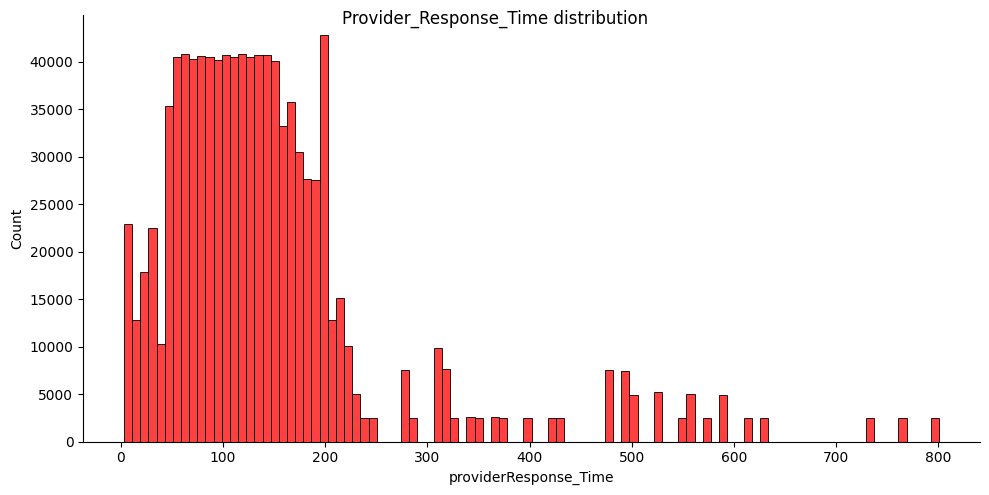

In [243]:
create_displot('providerResponse_Time', 'Provider_Response_Time distribution' )

### Dealing with Boolean and Numbers

These columns can be replace with boolian values:

 **log_level, method, planName, log_type, paymentType, call_type, api_type** 

 or in **planName** case they can encode with ordinary numbers like 1 2 3.

 **BUT** we keep them as they are, cause at the moment we dont have plan for any ML models.

In [244]:
df["code"] = df["code"].apply(lambda x : int(x))
df["Price"] = df["Price"].astype(int)
df["gwStatus"] = df["gwStatus"].astype(bool)
df["response_status"] = df["response_status"].astype(int)
df["status"] = df["status"].astype(bool)
df["gwCode"] = df["gwCode"].astype(int)

In [245]:
df.dtypes

log_level                 object
code                       int64
method                    object
username                  object
Price                      int64
gwStatus                    bool
planName                  object
received_at               object
log_type                  object
providerName              object
gatewayName               object
response_status            int64
status                      bool
response_Time            float64
paymentType               object
endpoint                  object
providerResponse_Time    float64
gwCode                     int64
call_type                 object
api_type                  object
dtype: object

## EDA

In [246]:
# finding top five username.
def top5_plot(column_name, color = 'pink'):
    plt.figure(figsize=(16, 4))
    plt.bar(df[column_name].value_counts()[0:5].index,df[column_name].value_counts()[0:5].values,color=color)
    plt.title(f"Top Five {column_name}")
    plt.show()


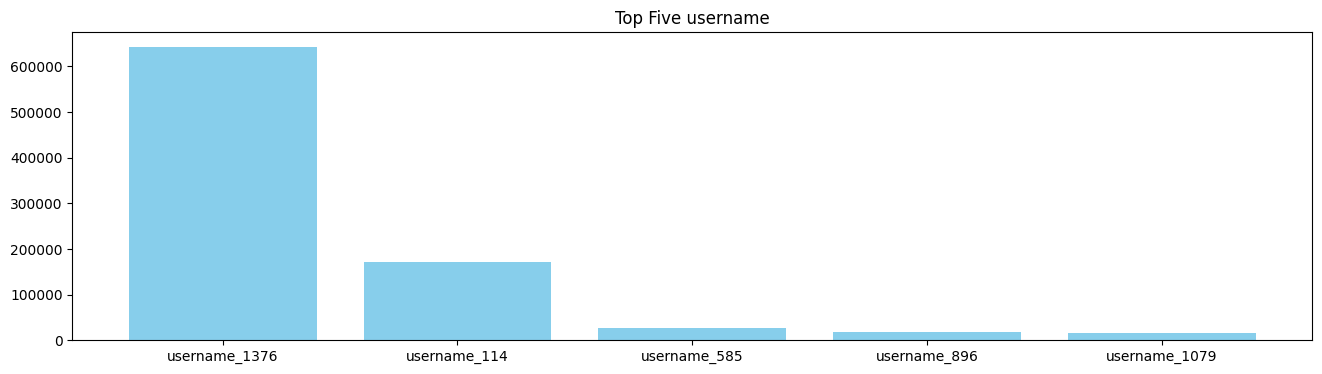

In [247]:
top5_plot('username','skyblue')

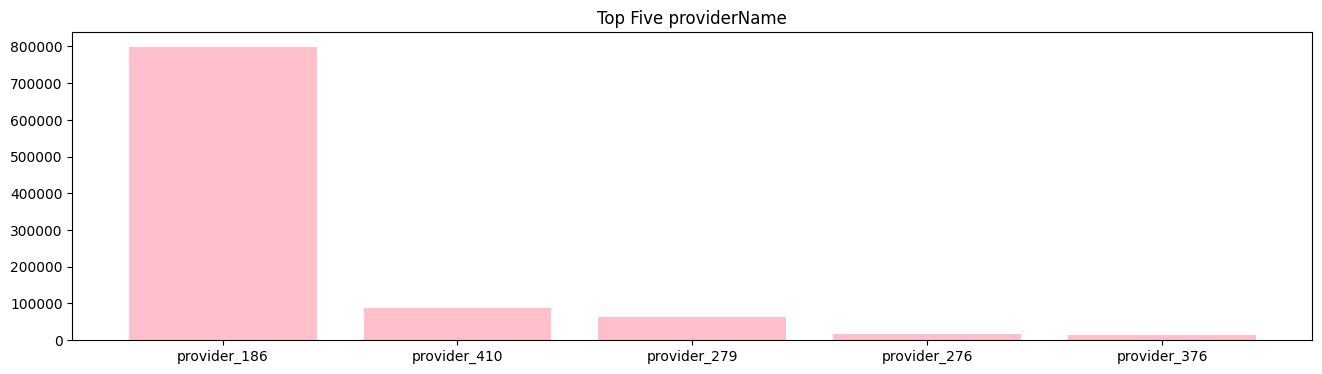

In [248]:
top5_plot('providerName')

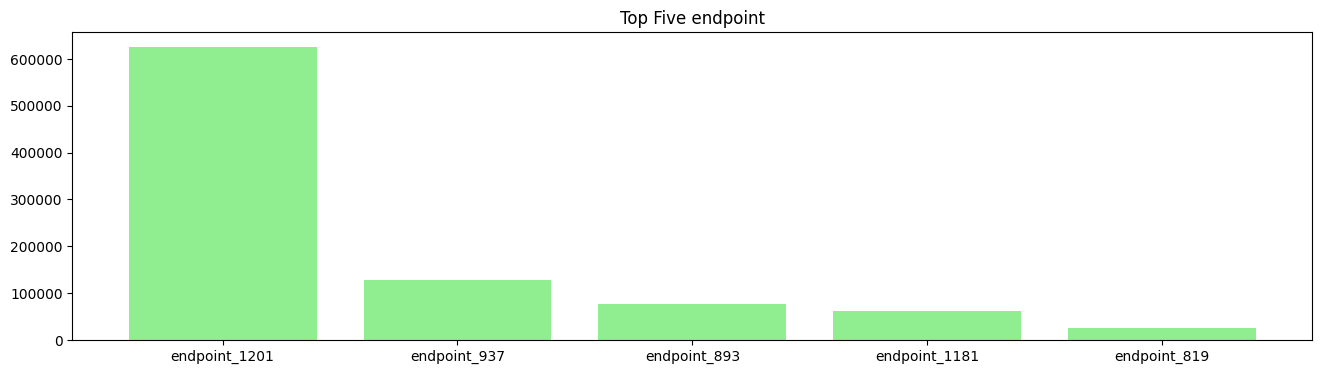

In [249]:
top5_plot('endpoint','lightgreen')

In [250]:
def create_pie(column_name, title):
    plt.figure(figsize=(4, 8))
    value_count = df[column_name].value_counts()
    plt.pie(
            value_count.values,
            labels = value_count.index,
            colors = ['teal','skyblue'],
            autopct =  '%1.1f%%'
            )
    plt.title(title)
    plt.show()

    

In [251]:
def count_percentage_plot_by_column(column_name,given_title,color_name = 'aqua',vertical = True):
    # global available_colors
    global df
    if column_name not in df.columns.tolist():
        raise Exception(f"Column with name '{column_name}' doesnt exists.")
    # if color_name not in available_colors:
    #     raise Exception(f"Color with name '{color_name}' doesnt exists.")
    count_percentage = [ round(i,2) for i in df[column_name].value_counts().values / df.shape[0] * 100]
    uniques_values = df[column_name].value_counts().index
    result = pd.DataFrame(
        {
            column_name : uniques_values,
            "count_percentage" : count_percentage
        }
    )
    if vertical:
        fig = px.bar(result, x = column_name, y = "count_percentage")
    else:
        fig = px.bar(result.sort_values('count_percentage'), y = column_name, x = "count_percentage",orientation='h')
    fig.update_layout(autosize=False,
    width=800,
    height=400,
    title = given_title,
    title_x=0.5
    )
    fig.update_traces(marker=dict(color= color_name))
    fig.show()

In [252]:
count_percentage_plot_by_column('log_level','Percentage of Log levels','aqua',False)

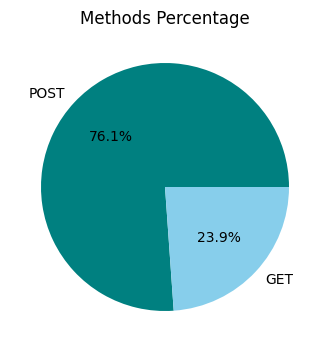

In [253]:
create_pie('method','Methods Percentage')

In [254]:
count_percentage_plot_by_column('Price','Different Prices Percentage','midnightblue',False)

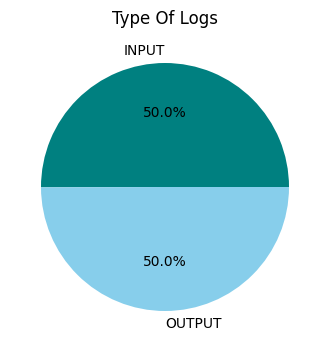

In [255]:
create_pie('log_type','Type Of Logs')

In [256]:
count_percentage_plot_by_column('planName','Different Plan Names','purple')

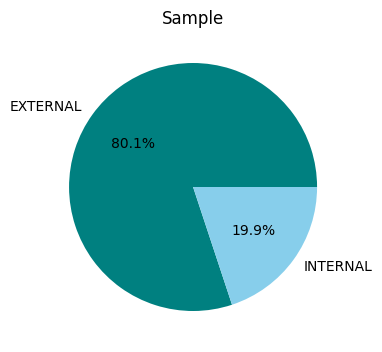

In [257]:
create_pie('call_type','Sample')

In [258]:
count_percentage_plot_by_column('api_type','Different API Types','pink',False)

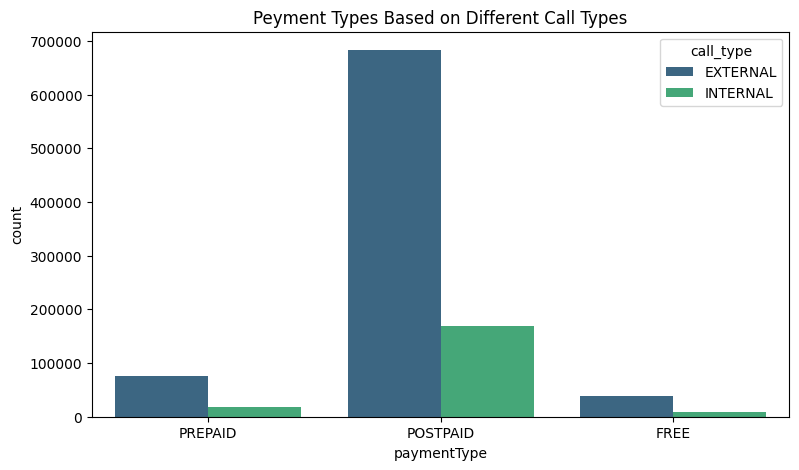

In [259]:
plt.figure(figsize=(9, 5))
sns.countplot(x='paymentType',data=df,hue='call_type',palette='viridis').set_title("Peyment Types Based on Different Call Types")
plt.show()

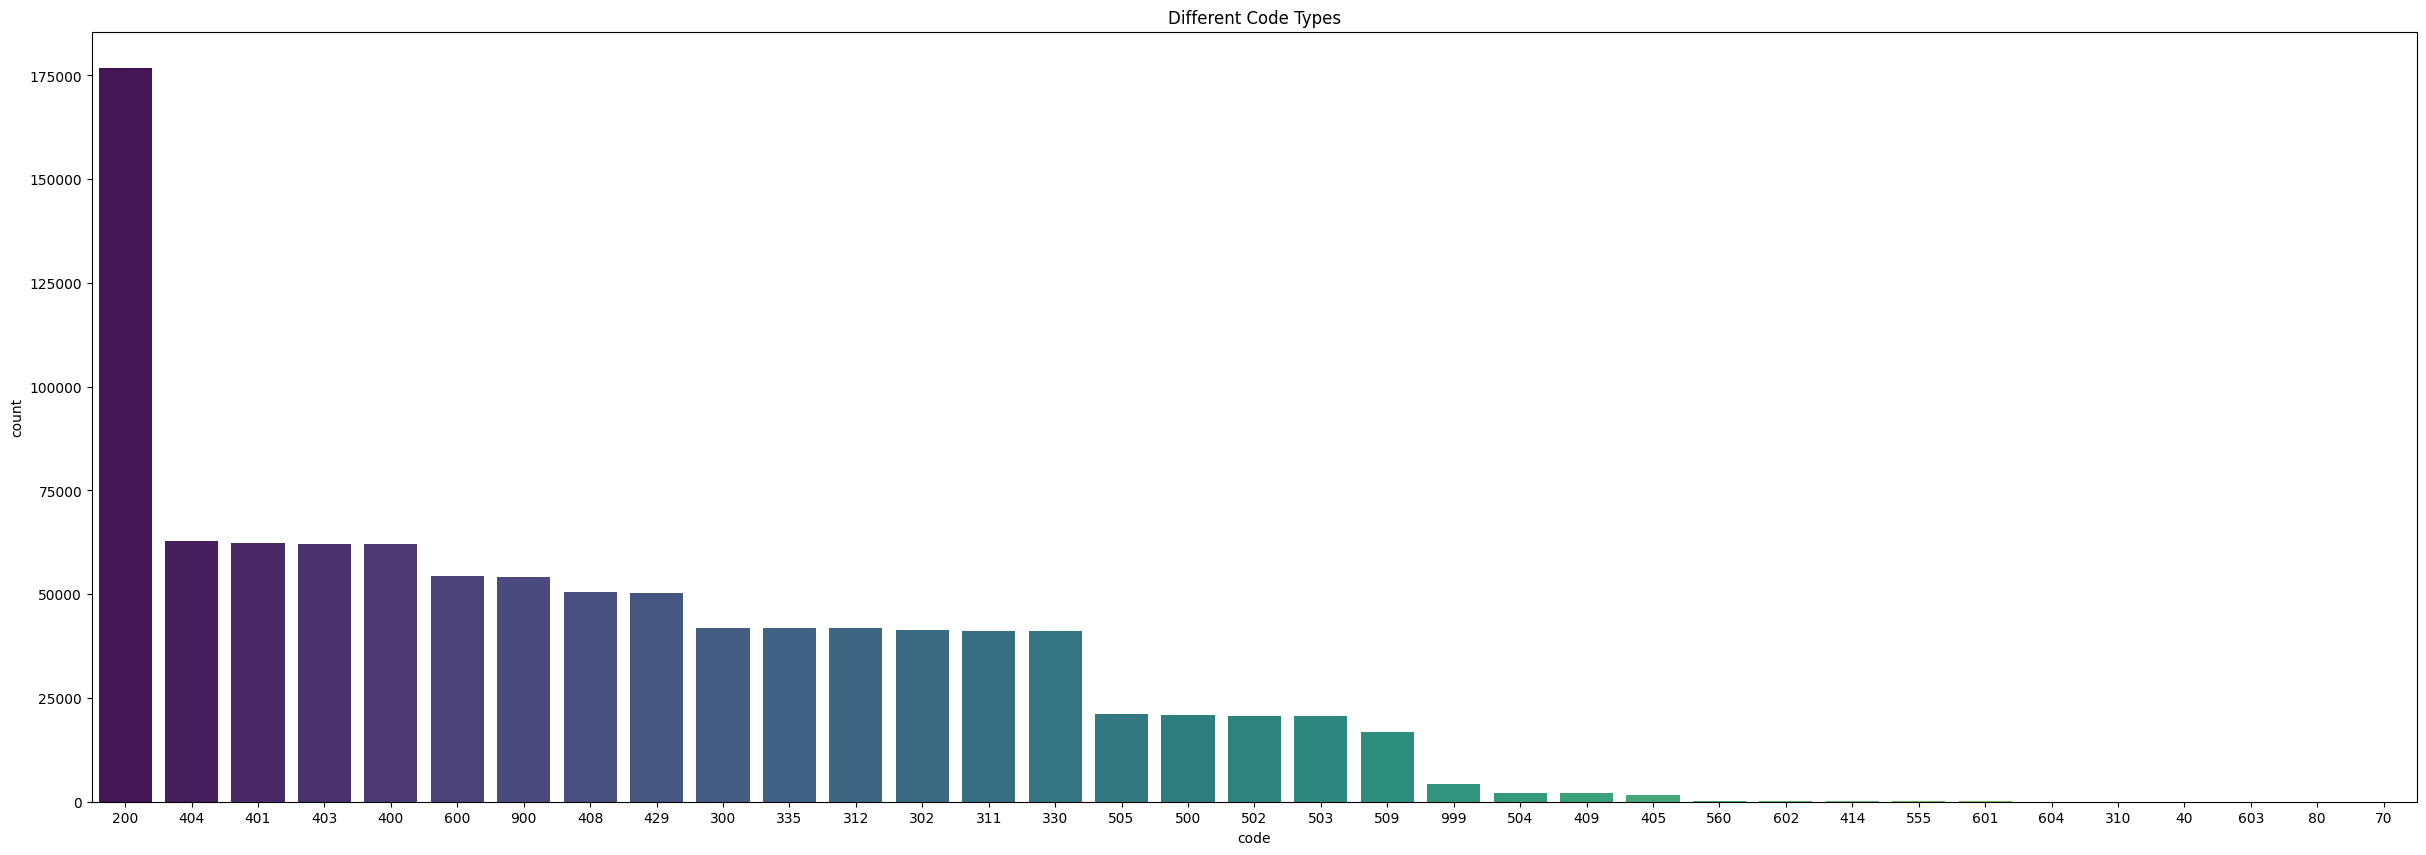

In [260]:
plt.figure(figsize=(30,10))
sns.countplot(x='code',data=df,palette='viridis',order=df['code'].value_counts().index).set_title("Different Code Types")
plt.show()

In [261]:
succesfull_transaction = go.Figure()
succesfull_transaction.add_trace(go.Indicator(
mode = "number+delta",
number = {'suffix': '%'},
value = sum(df['status'])/len(df)*100,
domain = {'row': 0, 'column': 1}))
succesfull_transaction.update_layout(autosize=False,
width=400,
height=400,
    title={
    'text': f"Successfull Transaction",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'}
)
succesfull_transaction.show()

In [262]:
sum(df['status'])/len(df)*100

100.0

## Feature Engineering and More Insight

### Latency

Latency means the diffrence between response_time and providerResponse_Time.

The latency shows the api management platfrom response time. 

In [263]:
df["latency"] = df["response_Time"] - df["providerResponse_Time"]

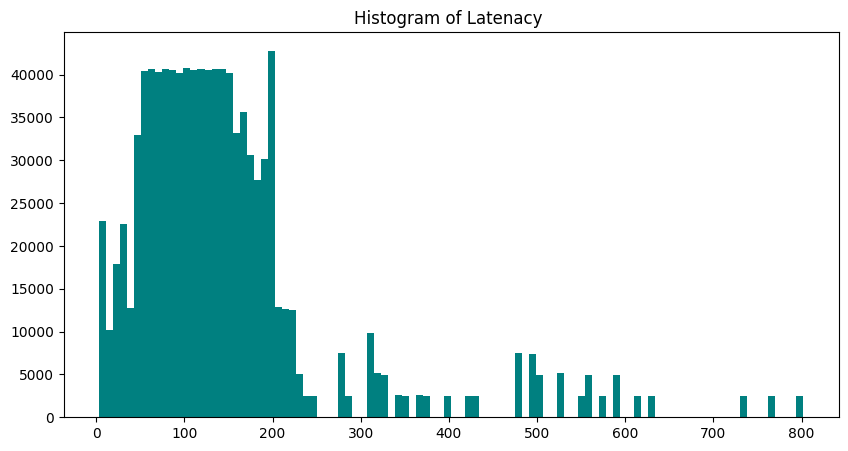

In [264]:
plt.figure(figsize=(10, 5))
plt.hist(df["latency"],color='teal', bins = 100)
plt.title("Histogram of Latenacy ")
plt.show()

In [265]:
# ERROR AND GOLD PLAN
error_and_goldplan = round( df[(df["log_level"] == "ERROR") & (df["planName"] == "Gold")].shape[0],2)

In [266]:
# ALL GOLD PLAN
all_goldplan = df[(df["planName"] == "Gold")].shape[0]

We can see the percentage of failed transactions in Gold plan. It is almost 8%

In [267]:
round(error_and_goldplan / all_goldplan * 100,2)

8.27

Because of 92% of good performance in gold plan, we can claim that the problem 

*   List item
*   List item

is from provider side and **not** from api management side.
Now let's check if we have a bad performer provider with huge amount of failed transaction who has a gold plan.

In [268]:
df[(df["log_level"] == "ERROR") & (df["planName"] == "Gold")]["providerName"].value_counts()

provider_186     13220
provider_410      1453
provider_279      1007
provider_276       275
provider_376       232
provider_189        72
provider_290        66
provider_1050       22
provider_562        19
provider_1189       18
provider_800        17
provider_715        12
provider_955        10
provider_89         10
provider_1386        8
provider_1226        6
provider_322         3
provider_457         2
provider_1421        1
Name: providerName, dtype: int64

The Worst one is **provider_186**, after it  provider_410, provider_279, provider_376 respectively. We should notif them to solve the problem.

### Dealing with Date type

In [269]:
# Convert object type to datetime type
df["received_at"] = pd.to_datetime(df["received_at"], utc = True)

In [270]:
# Create some new columns from received_at column
df["received_at_short"] = df["received_at"].dt.date
df["Year"] = df["received_at"].dt.year
df["Month"] = df["received_at"].dt.month
df["Day"] = df["received_at"].dt.day
df['Day of Week'] = df['received_at'].apply(lambda time: time.dayofweek)
df['Hour'] = df['received_at'].apply(lambda time: time.hour)

dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['Day of Week'] = df['Day of Week'].map(dmap)

### Relations

In [271]:
df.columns

Index(['log_level', 'code', 'method', 'username', 'Price', 'gwStatus',
       'planName', 'received_at', 'log_type', 'providerName', 'gatewayName',
       'response_status', 'status', 'response_Time', 'paymentType', 'endpoint',
       'providerResponse_Time', 'gwCode', 'call_type', 'api_type', 'latency',
       'received_at_short', 'Year', 'Month', 'Day', 'Day of Week', 'Hour'],
      dtype='object')

In [272]:
df.drop(["gwStatus","status"], axis = 1).corr()

<ipython-input-272-4352ecaa0986>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,code,Price,response_status,response_Time,providerResponse_Time,gwCode,latency,Year,Month,Day,Hour
code,1.000000,0.001940,0.000993,-0.000741,-0.000742,-0.000986,-0.000741,0.001078,0.000113,0.000442,-0.000688
Price,0.001940,1.000000,0.001057,0.000894,0.000896,0.000227,0.000892,-0.000686,0.000380,0.000952,-0.001048
response_status,0.000993,0.001057,1.000000,0.000352,0.000350,0.000702,0.000354,-0.000868,0.000471,0.000333,0.000147
response_Time,-0.000741,0.000894,0.000352,1.000000,0.999998,-0.000183,0.999998,0.000092,0.000842,0.000465,-0.001281
providerResponse_Time,-0.000742,0.000896,0.000350,0.999998,1.000000,-0.000184,0.999992,0.000092,0.000841,0.000466,-0.001282
gwCode,-0.000986,0.000227,0.000702,-0.000183,-0.000184,1.000000,-0.000183,-0.000127,0.001210,0.000858,0.000364
latency,-0.000741,0.000892,0.000354,0.999998,0.999992,-0.000183,1.000000,0.000091,0.000843,0.000465,-0.001281
Year,0.001078,-0.000686,-0.000868,0.000092,0.000092,-0.000127,0.000091,1.000000,-0.436736,-0.057073,0.000670
Month,0.000113,0.000380,0.000471,0.000842,0.000841,0.001210,0.000843,-0.436736,1.000000,0.005584,-0.001122
Day,0.000442,0.000952,0.000333,0.000465,0.000466,0.000858,0.000465,-0.057073,0.005584,1.000000,0.001168


Because this is the mock data and also a lot our features are categorical, we dont have any correlation between features.

In [273]:
#Grouping trasaction based on month for different codes
byMonth = df.groupby( by=['Month']).count().reset_index()
byMonth200 = df[df['code']==200].groupby('Month').count().reset_index()
byMontherror = df[df['code']!=200].groupby('Month').count().reset_index()
byMonth200.head()

,Month,log_level,code,method,username,Price,gwStatus,planName,received_at,log_type,...,providerResponse_Time,gwCode,call_type,api_type,latency,received_at_short,Year,Day,Day of Week,Hour
0,1,15338,15338,15338,15338,15338,15338,15338,15338,15338,...,15338,15338,15338,15338,15338,15338,15338,15338,15338,15338
1,2,13943,13943,13943,13943,13943,13943,13943,13943,13943,...,13943,13943,13943,13943,13943,13943,13943,13943,13943,13943
2,3,15630,15630,15630,15630,15630,15630,15630,15630,15630,...,15630,15630,15630,15630,15630,15630,15630,15630,15630,15630
3,4,14174,14174,14174,14174,14174,14174,14174,14174,14174,...,14174,14174,14174,14174,14174,14174,14174,14174,14174,14174
4,5,14550,14550,14550,14550,14550,14550,14550,14550,14550,...,14550,14550,14550,14550,14550,14550,14550,14550,14550,14550


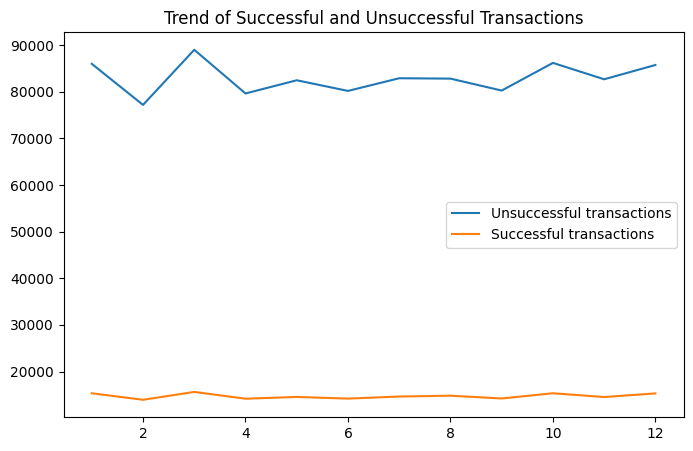

In [274]:
plt.figure(figsize=(8, 5))
plt.plot(byMontherror['Month'], byMonth['code'], label = "Unsuccessful transactions")
plt.plot(byMonth200['Month'], byMonth200['code'], label = "Successful transactions")
plt.legend()
plt.title("Trend of Successful and Unsuccessful Transactions")
plt.show()

In [275]:
#Grouping trasaction based on hour of day and day of week
dayHour = df.groupby(by=['Day of Week','Hour']).count()['code'].unstack()
dayHour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,6031,5752,5935,5975,5922,6032,6008,6006,5957,6028,...,6034,5782,5911,5856,5884,5917,5885,6085,5891,5907
Mon,6034,5845,5851,5771,5913,5922,6051,5871,5916,5964,...,5767,5915,5758,5977,5902,5951,5886,5932,5972,5972
Sat,5825,5932,5881,5983,6083,5867,5937,6029,5958,5983,...,5901,5964,5856,5853,6027,6005,6026,5969,5851,5867
Sun,5868,5800,5984,6011,5951,5833,5969,5912,6007,5994,...,5924,5970,6062,6017,5873,5855,5921,5837,6033,5863
Thu,5898,5924,5885,5932,5948,5818,5822,5861,5986,5756,...,5852,6117,5877,5944,5867,5940,6028,5902,5940,6001


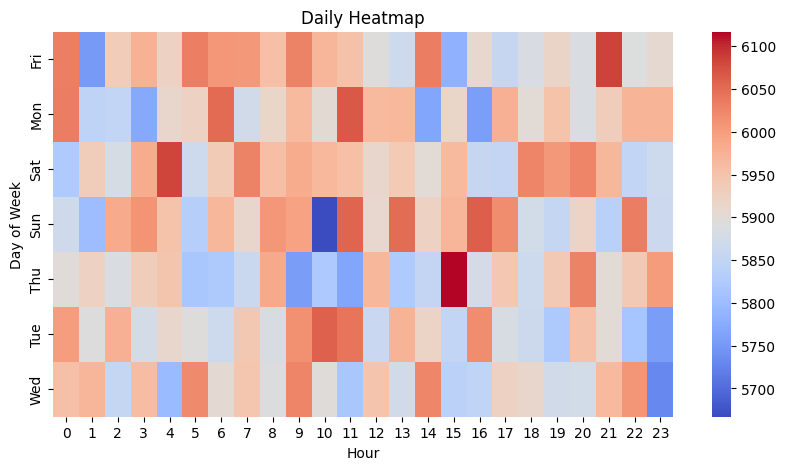

In [276]:
plt.figure(figsize=(10, 5))
sns.heatmap(dayHour,cmap='coolwarm').set_title("Daily Heatmap")
plt.show()

In [277]:
#Grouping trasaction based on month and day of week.
dayMonth = df.groupby(by=['Day of Week','Month']).count()['code'].unstack()
dayMonth.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Day of Week,,,,,,,,,,,,
Fri,9598,11386,11955,14592,9062,11828,12278,11186,14329,9771,11820,14677
Mon,14556,11729,12029,9100,14385,9242,11805,12456,11273,14005,10045,11447
Sat,12726,9169,11952,13958,9990,11260,14825,9057,11873,12665,11056,14039
Sun,14594,9525,11978,11180,14942,9045,14086,9617,11717,14630,9234,11820
Thu,8974,11777,14202,12361,8937,13954,9537,11672,12387,11670,11638,14568


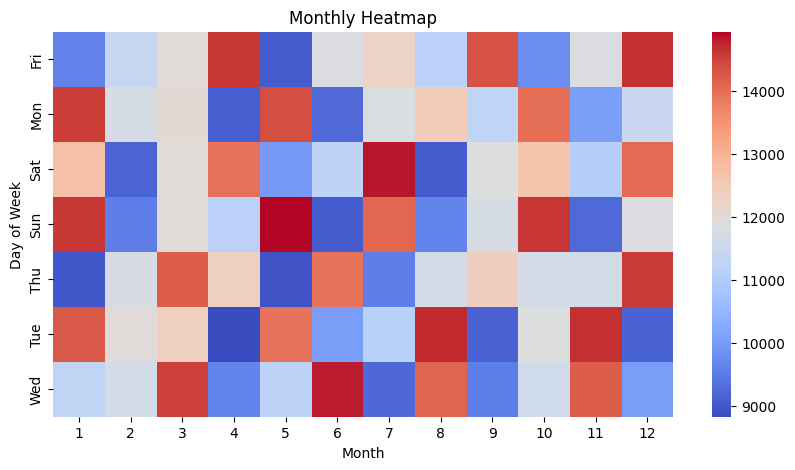

In [278]:
plt.figure(figsize=(10, 5))
sns.heatmap(dayMonth,cmap='coolwarm').set_title("Monthly Heatmap")
plt.show()

### Loss Money For ERROR By Provider Name

In [279]:
def loss_money_by_provider(pname):
    if pname not in df["providerName"].unique():
        raise Exception(f"This provider name {pname} doesnt exists in provider names list.")
    lost_money = df[(df["log_level"] == "ERROR") & (df["providerName"] == pname)]["Price"].sum()
    fig = go.Figure()
    fig.add_trace(go.Indicator(
    mode = "number+delta",
    value = lost_money,
    domain = {'row': 0, 'column': 1}))
    fig.update_layout(autosize=False,
    width=400,
    height=400,
        title={
        'text': f"Loss Money for {pname}",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    )
    fig.show()

In [280]:
loss_money_by_provider("provider_186")

Notify Providers who having Gold plan but *don't serve well*.

### Export Data to use in Power BI and Superset

In [281]:
df.to_parquet("api_management_final.parquet")